#  Evaluating the Influence of Hidden Layer Size Adjustments on Multi-Layer Perceptron Classification

# By James Boyd

Setup

In [10]:
import run_test

In [11]:
import numpy as np
import pandas as pd

class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model, v1.02'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels).reset_index(drop=True)], axis=1, ignore_index=True)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
        self.image_indices = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['labls'].sum()
        self.performance_measures['Neg'] = self.performance_df['labls'].shape[0] - self.performance_df['labls'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])
        self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
        self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']
        self.performance_measures['desc'] = self.desc

    def img_indices(self):
        '''Get the indices of true and false positives to be able to locate the corresponding images in a list of image names'''
        self.performance_df['tp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True))
        self.performance_df['fp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False))
        self.image_indices['TP_indices'] = np.where(self.performance_df['tp_ind']==True)[0].tolist()
        self.image_indices['FP_indices'] = np.where(self.performance_df['fp_ind']==True)[0].tolist()

In [12]:
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline



In [14]:
help(BinaryClassificationPerformance)


Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [15]:
ci_path = 'Desktop/ml/final_assignment_2/plane_data/cropped_images/' # file path for cropped images for training
l_file = 'Desktop/ml/final_assignment_2/plane_data/plane_labels.csv' # file path and file name for csv with labels


Feature Building and Extraction with Hysteresis Thresholding Representation

In [16]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

downscaled image shape: 
(15, 35)
image representation (first row of pixels): 
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


example of transformation: 


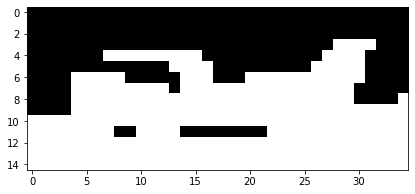

In [36]:
import matplotlib.pyplot as plt
from skimage import filters
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    low = 0.3
    high = 0.7
    final_image = filters.apply_hysteresis_threshold(downscaled, low, high) # hysteresis thresholding
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

In [20]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)

In [37]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=20, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
82
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
19
Shape of data_train and data_test:
(5068, 525)
(1690, 525)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


In [38]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')

62 Trials with HLS Adjustments:

In [106]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100,100, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1668, 'FP': 3, 'FN': 7, 'Accuracy': 0.9940828402366864, 'Precision': 0.8, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [107]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100,80, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100, 100, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 45, 'TN': 4986, 'FP': 0, 'FN': 37, 'Accuracy': 0.9926992896606156, 'Precision': 1.0, 'Recall': 0.5487804878048781, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1665, 'FP': 6, 'FN': 7, 'Accuracy': 0.9923076923076923, 'Precision': 0.6666666666666666, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [108]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,80,80, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100, 80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1668, 'FP': 3, 'FN': 8, 'Accuracy': 0.993491124260355, 'Precision': 0.7857142857142857, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [109]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,80,80,80, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 80, 80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 48, 'TN': 4986, 'FP': 0, 'FN': 34, 'Accuracy': 0.9932912391475928, 'Precision': 1.0, 'Recall': 0.5853658536585366, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1669, 'FP': 2, 'FN': 9, 'Accuracy': 0.993491124260355, 'Precision': 0.8333333333333334, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [110]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80,80,80, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80, 80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [111]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80,80,60, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80, 80, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1668, 'FP': 3, 'FN': 6, 'Accuracy': 0.9946745562130177, 'Precision': 0.8125, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [112]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80,60,60, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80, 60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1668, 'FP': 3, 'FN': 9, 'Accuracy': 0.9928994082840237, 'Precision': 0.7692307692307693, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [113]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,60,60,60, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 60, 60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1667, 'FP': 4, 'FN': 8, 'Accuracy': 0.9928994082840237, 'Precision': 0.7333333333333333, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [114]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60,60,60, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60, 60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 57, 'TN': 4986, 'FP': 0, 'FN': 25, 'Accuracy': 0.995067087608524, 'Precision': 1.0, 'Recall': 0.6951219512195121, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1667, 'FP': 4, 'FN': 6, 'Accuracy': 0.9940828402366864, 'Precision': 0.7647058823529411, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [115]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60,60,40, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60, 60, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [116]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60,40,40, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60, 40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 44, 'TN': 4986, 'FP': 0, 'FN': 38, 'Accuracy': 0.9925019731649566, 'Precision': 1.0, 'Recall': 0.5365853658536586, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1671, 'FP': 0, 'FN': 8, 'Accuracy': 0.9952662721893492, 'Precision': 1.0, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [117]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,40,40,40, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 40, 40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 50, 'TN': 4986, 'FP': 0, 'FN': 32, 'Accuracy': 0.9936858721389108, 'Precision': 1.0, 'Recall': 0.6097560975609756, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1670, 'FP': 1, 'FN': 7, 'Accuracy': 0.9952662721893492, 'Precision': 0.9230769230769231, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [118]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40,40,40, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40, 40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 51, 'TN': 4986, 'FP': 0, 'FN': 31, 'Accuracy': 0.9938831886345698, 'Precision': 1.0, 'Recall': 0.6219512195121951, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [119]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40,40,20, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40, 40, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1667, 'FP': 4, 'FN': 10, 'Accuracy': 0.991715976331361, 'Precision': 0.6923076923076923, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [120]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40,20,20, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40, 20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 47, 'TN': 4986, 'FP': 0, 'FN': 35, 'Accuracy': 0.9930939226519337, 'Precision': 1.0, 'Recall': 0.573170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1668, 'FP': 3, 'FN': 9, 'Accuracy': 0.9928994082840237, 'Precision': 0.7692307692307693, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [121]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,20,20,20, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 20, 20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 50, 'TN': 4986, 'FP': 0, 'FN': 32, 'Accuracy': 0.9936858721389108, 'Precision': 1.0, 'Recall': 0.6097560975609756, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1669, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.8571428571428571, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [122]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20,20, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20, 20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 13, 'TN': 4986, 'FP': 0, 'FN': 69, 'Accuracy': 0.9863851617995264, 'Precision': 1.0, 'Recall': 0.15853658536585366, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 2, 'TN': 1669, 'FP': 2, 'FN': 17, 'Accuracy': 0.9887573964497042, 'Precision': 0.5, 'Recall': 0.10526315789473684, 'desc': 'nn_test', 'set': 'test'}


In [123]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20,10, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20, 20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1667, 'FP': 4, 'FN': 10, 'Accuracy': 0.991715976331361, 'Precision': 0.6923076923076923, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [124]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,10,10, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20, 10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 56, 'TN': 4986, 'FP': 0, 'FN': 26, 'Accuracy': 0.994869771112865, 'Precision': 1.0, 'Recall': 0.6829268292682927, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1668, 'FP': 3, 'FN': 6, 'Accuracy': 0.9946745562130177, 'Precision': 0.8125, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [204]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,10,10,10, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 10, 10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 56, 'TN': 4986, 'FP': 0, 'FN': 26, 'Accuracy': 0.994869771112865, 'Precision': 1.0, 'Recall': 0.6829268292682927, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1669, 'FP': 2, 'FN': 8, 'Accuracy': 0.9940828402366864, 'Precision': 0.8461538461538461, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [127]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(10,10,10,10, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 59, 'TN': 4986, 'FP': 0, 'FN': 23, 'Accuracy': 0.9954617205998422, 'Precision': 1.0, 'Recall': 0.7195121951219512, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [129]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,80,60,40, ), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 80, 60, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 43, 'TN': 4986, 'FP': 0, 'FN': 39, 'Accuracy': 0.9923046566692976, 'Precision': 1.0, 'Recall': 0.524390243902439, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1668, 'FP': 3, 'FN': 8, 'Accuracy': 0.993491124260355, 'Precision': 0.7857142857142857, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [130]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,60,40,20), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 60, 40, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1669, 'FP': 2, 'FN': 6, 'Accuracy': 0.9952662721893492, 'Precision': 0.8666666666666667, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [131]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,40,20,10), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 40, 20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 43, 'TN': 4985, 'FP': 1, 'FN': 39, 'Accuracy': 0.9921073401736386, 'Precision': 0.9772727272727273, 'Recall': 0.524390243902439, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1669, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.8571428571428571, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [132]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4985, 'FP': 1, 'FN': 36, 'Accuracy': 0.9926992896606156, 'Precision': 0.9787234042553191, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1667, 'FP': 4, 'FN': 7, 'Accuracy': 0.993491124260355, 'Precision': 0.75, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [202]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,80,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1668, 'FP': 3, 'FN': 6, 'Accuracy': 0.9946745562130177, 'Precision': 0.8125, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [195]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,80,80,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 43, 'TN': 4986, 'FP': 0, 'FN': 39, 'Accuracy': 0.9923046566692976, 'Precision': 1.0, 'Recall': 0.524390243902439, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 6, 'TN': 1670, 'FP': 1, 'FN': 13, 'Accuracy': 0.991715976331361, 'Precision': 0.8571428571428571, 'Recall': 0.3157894736842105, 'desc': 'nn_test', 'set': 'test'}


In [135]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,80,60,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 80, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1668, 'FP': 3, 'FN': 7, 'Accuracy': 0.9940828402366864, 'Precision': 0.8, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [136]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80,80,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 49, 'TN': 4986, 'FP': 0, 'FN': 33, 'Accuracy': 0.9934885556432518, 'Precision': 1.0, 'Recall': 0.5975609756097561, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1666, 'FP': 5, 'FN': 10, 'Accuracy': 0.9911242603550295, 'Precision': 0.6428571428571429, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [190]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80,60,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 47, 'TN': 4986, 'FP': 0, 'FN': 35, 'Accuracy': 0.9930939226519337, 'Precision': 1.0, 'Recall': 0.573170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1669, 'FP': 2, 'FN': 6, 'Accuracy': 0.9952662721893492, 'Precision': 0.8666666666666667, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [188]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,60,60,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices


MLPClassifier(hidden_layer_sizes=(80, 60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 51, 'TN': 4986, 'FP': 0, 'FN': 31, 'Accuracy': 0.9938831886345698, 'Precision': 1.0, 'Recall': 0.6219512195121951, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1668, 'FP': 3, 'FN': 8, 'Accuracy': 0.993491124260355, 'Precision': 0.7857142857142857, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [189]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,60,40,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 60, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 59, 'TN': 4986, 'FP': 0, 'FN': 23, 'Accuracy': 0.9954617205998422, 'Precision': 1.0, 'Recall': 0.7195121951219512, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1668, 'FP': 3, 'FN': 7, 'Accuracy': 0.9940828402366864, 'Precision': 0.8, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [139]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60,60,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 51, 'TN': 4986, 'FP': 0, 'FN': 31, 'Accuracy': 0.9938831886345698, 'Precision': 1.0, 'Recall': 0.6219512195121951, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1667, 'FP': 4, 'FN': 7, 'Accuracy': 0.993491124260355, 'Precision': 0.75, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [141]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60,40,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 47, 'TN': 4986, 'FP': 0, 'FN': 35, 'Accuracy': 0.9930939226519337, 'Precision': 1.0, 'Recall': 0.573170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1669, 'FP': 2, 'FN': 9, 'Accuracy': 0.993491124260355, 'Precision': 0.8333333333333334, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [143]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,40,40,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 41, 'TN': 4986, 'FP': 0, 'FN': 41, 'Accuracy': 0.9919100236779794, 'Precision': 1.0, 'Recall': 0.5, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1669, 'FP': 2, 'FN': 10, 'Accuracy': 0.9928994082840237, 'Precision': 0.8181818181818182, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [144]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,40,20,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 40, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 54, 'TN': 4986, 'FP': 0, 'FN': 28, 'Accuracy': 0.994475138121547, 'Precision': 1.0, 'Recall': 0.6585365853658537, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1667, 'FP': 4, 'FN': 6, 'Accuracy': 0.9940828402366864, 'Precision': 0.7647058823529411, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [145]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40,40,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1668, 'FP': 3, 'FN': 8, 'Accuracy': 0.993491124260355, 'Precision': 0.7857142857142857, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [156]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40,20,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 52, 'TN': 4986, 'FP': 0, 'FN': 30, 'Accuracy': 0.9940805051302289, 'Precision': 1.0, 'Recall': 0.6341463414634146, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1668, 'FP': 3, 'FN': 9, 'Accuracy': 0.9928994082840237, 'Precision': 0.7692307692307693, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [176]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,20,20), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 52, 'TN': 4986, 'FP': 0, 'FN': 30, 'Accuracy': 0.9940805051302289, 'Precision': 1.0, 'Recall': 0.6341463414634146, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1670, 'FP': 1, 'FN': 9, 'Accuracy': 0.9940828402366864, 'Precision': 0.9090909090909091, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [158]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,20,10,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 59, 'TN': 4986, 'FP': 0, 'FN': 23, 'Accuracy': 0.9954617205998422, 'Precision': 1.0, 'Recall': 0.7195121951219512, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1670, 'FP': 1, 'FN': 6, 'Accuracy': 0.9958579881656805, 'Precision': 0.9285714285714286, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [159]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 54, 'TN': 4984, 'FP': 2, 'FN': 28, 'Accuracy': 0.9940805051302289, 'Precision': 0.9642857142857143, 'Recall': 0.6585365853658537, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1669, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.8571428571428571, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [160]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,10,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 53, 'TN': 4986, 'FP': 0, 'FN': 29, 'Accuracy': 0.994277821625888, 'Precision': 1.0, 'Recall': 0.6463414634146342, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1671, 'FP': 0, 'FN': 9, 'Accuracy': 0.9946745562130177, 'Precision': 1.0, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [161]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,10,10,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 59, 'TN': 4986, 'FP': 0, 'FN': 23, 'Accuracy': 0.9954617205998422, 'Precision': 1.0, 'Recall': 0.7195121951219512, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1670, 'FP': 1, 'FN': 7, 'Accuracy': 0.9952662721893492, 'Precision': 0.9230769230769231, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [162]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,10,5,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 10, 5), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1667, 'FP': 4, 'FN': 10, 'Accuracy': 0.991715976331361, 'Precision': 0.6923076923076923, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [163]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(10,10,10,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 52, 'TN': 4986, 'FP': 0, 'FN': 30, 'Accuracy': 0.9940805051302289, 'Precision': 1.0, 'Recall': 0.6341463414634146, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1670, 'FP': 1, 'FN': 10, 'Accuracy': 0.993491124260355, 'Precision': 0.9, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [164]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 51, 'TN': 4986, 'FP': 0, 'FN': 31, 'Accuracy': 0.9938831886345698, 'Precision': 1.0, 'Recall': 0.6219512195121951, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1670, 'FP': 1, 'FN': 7, 'Accuracy': 0.9952662721893492, 'Precision': 0.9230769230769231, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [167]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,80), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(100, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 57, 'TN': 4986, 'FP': 0, 'FN': 25, 'Accuracy': 0.995067087608524, 'Precision': 1.0, 'Recall': 0.6951219512195121, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1669, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.8571428571428571, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [168]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,80), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 80), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 46, 'TN': 4986, 'FP': 0, 'FN': 36, 'Accuracy': 0.9928966061562746, 'Precision': 1.0, 'Recall': 0.5609756097560976, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 8, 'TN': 1669, 'FP': 2, 'FN': 11, 'Accuracy': 0.9923076923076923, 'Precision': 0.8, 'Recall': 0.42105263157894735, 'desc': 'nn_test', 'set': 'test'}


In [169]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80,60), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(80, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1668, 'FP': 3, 'FN': 7, 'Accuracy': 0.9940828402366864, 'Precision': 0.8, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [170]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,60), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [173]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60,40), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(60, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1667, 'FP': 4, 'FN': 7, 'Accuracy': 0.993491124260355, 'Precision': 0.75, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [174]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,40), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1670, 'FP': 1, 'FN': 7, 'Accuracy': 0.9952662721893492, 'Precision': 0.9230769230769231, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [175]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40,20,), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(40, 40), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 56, 'TN': 4986, 'FP': 0, 'FN': 26, 'Accuracy': 0.994869771112865, 'Precision': 1.0, 'Recall': 0.6829268292682927, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1670, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9166666666666666, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [177]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 48, 'TN': 4986, 'FP': 0, 'FN': 34, 'Accuracy': 0.9932912391475928, 'Precision': 1.0, 'Recall': 0.5853658536585366, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 10, 'TN': 1669, 'FP': 2, 'FN': 9, 'Accuracy': 0.993491124260355, 'Precision': 0.8333333333333334, 'Recall': 0.5263157894736842, 'desc': 'nn_test', 'set': 'test'}


In [178]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,10), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 57, 'TN': 4985, 'FP': 1, 'FN': 25, 'Accuracy': 0.994869771112865, 'Precision': 0.9827586206896551, 'Recall': 0.6951219512195121, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 13, 'TN': 1666, 'FP': 5, 'FN': 6, 'Accuracy': 0.993491124260355, 'Precision': 0.7222222222222222, 'Recall': 0.6842105263157895, 'desc': 'nn_test', 'set': 'test'}


In [180]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 56, 'TN': 4986, 'FP': 0, 'FN': 26, 'Accuracy': 0.994869771112865, 'Precision': 1.0, 'Recall': 0.6829268292682927, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 8, 'TN': 1671, 'FP': 0, 'FN': 11, 'Accuracy': 0.993491124260355, 'Precision': 1.0, 'Recall': 0.42105263157894735, 'desc': 'nn_test', 'set': 'test'}


In [181]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(100), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=100, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1667, 'FP': 4, 'FN': 7, 'Accuracy': 0.993491124260355, 'Precision': 0.75, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [182]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(80), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=80, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 57, 'TN': 4986, 'FP': 0, 'FN': 25, 'Accuracy': 0.995067087608524, 'Precision': 1.0, 'Recall': 0.6951219512195121, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 12, 'TN': 1669, 'FP': 2, 'FN': 7, 'Accuracy': 0.9946745562130177, 'Precision': 0.8571428571428571, 'Recall': 0.631578947368421, 'desc': 'nn_test', 'set': 'test'}


In [183]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(60), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=60, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 58, 'TN': 4986, 'FP': 0, 'FN': 24, 'Accuracy': 0.9952644041041832, 'Precision': 1.0, 'Recall': 0.7073170731707317, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 11, 'TN': 1668, 'FP': 3, 'FN': 8, 'Accuracy': 0.993491124260355, 'Precision': 0.7857142857142857, 'Recall': 0.5789473684210527, 'desc': 'nn_test', 'set': 'test'}


In [184]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(40), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=40, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 51, 'TN': 4986, 'FP': 0, 'FN': 31, 'Accuracy': 0.9938831886345698, 'Precision': 1.0, 'Recall': 0.6219512195121951, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1670, 'FP': 1, 'FN': 10, 'Accuracy': 0.993491124260355, 'Precision': 0.9, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [185]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(20), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=20, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 48, 'TN': 4986, 'FP': 0, 'FN': 34, 'Accuracy': 0.9932912391475928, 'Precision': 1.0, 'Recall': 0.5853658536585366, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 9, 'TN': 1670, 'FP': 1, 'FN': 10, 'Accuracy': 0.993491124260355, 'Precision': 0.9, 'Recall': 0.47368421052631576, 'desc': 'nn_test', 'set': 'test'}


In [186]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(10), max_iter=1000)

print(nn)
nn.fit(data_train, y_train)


nn_performance_4 = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance_4.compute_measures()
nn_performance_4.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_4.performance_measures)

nn_performance_test_4 = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test_4.compute_measures()
nn_performance_test_4.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_4.performance_measures)

nn_performance_test_4.img_indices()
nn_img_indices_to_view_4 = nn_performance_test_4.image_indices

MLPClassifier(hidden_layer_sizes=10, max_iter=1000)
TRAINING SET: 
{'Pos': 82, 'Neg': 4986, 'TP': 53, 'TN': 4986, 'FP': 0, 'FN': 29, 'Accuracy': 0.994277821625888, 'Precision': 1.0, 'Recall': 0.6463414634146342, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 7, 'TN': 1665, 'FP': 6, 'FN': 12, 'Accuracy': 0.9893491124260355, 'Precision': 0.5384615384615384, 'Recall': 0.3684210526315789, 'desc': 'nn_test', 'set': 'test'}
